In [1]:
import numpy as np
import sys
import gsw
import glob
import xarray as xr
import numpy as np
from scipy import integrate
from scipy import interpolate
from copy import deepcopy 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import cmocean
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

In [3]:
## Load 2D Monthly data...SSH 
data_dir= ECCO_dir + '/nctiles_monthly'
# ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['SSHDYN','OBPNOPAB', 'RHOAnoma'], \
#                                                              years_to_load=range(2011,2018)).load() # ,'PHIHYD','RHOAnoma','SALT','UVEL','VVEL'    
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['ETAN', 'PHIBOT'],\
                                           years_to_load=range(1993,2018)).load()    
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))
tile_num = 10
lons = ecco_monthly_ds.XC.sel(tile=tile_num)
lats = ecco_monthly_ds.YC.sel(tile=tile_num)

loading files of  ETAN
loading files of  PHIBOT


In [4]:
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask)

In [5]:
# bathymetry
dep = ecco_monthly_ds.Depth
dep = dep.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

In [6]:
SSH_global_mean_mon = (ecco_monthly_ds.ETAN*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
ssh_mgm = ecco_monthly_ds.ETAN - SSH_global_mean_mon  # subtract global spatial mean time series 
ssh_anom = ssh_mgm - ssh_mgm.mean(dim='time') 
ssh_anom = ssh_anom.where(ocean_mask==1, np.nan)
ssh_anom = ssh_anom.isel(tile=tile_num)
ssh_anom_2 = ecco_monthly_ds.ETAN - ecco_monthly_ds.ETAN.mean(dim='time')
ssh_anom_2 = ssh_anom_2.where(ocean_mask==1, np.nan)
ssh_anom_2 = ssh_anom_2.isel(tile=tile_num)

In [7]:
# AVISO SLA 
# av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_obs_ssh_allsat_l4_pt25deg_P1D_1644446947552_2011_2017.nc'
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_obs_ssh_my_allsat_l4_duacs_ptdeg_P1D_1993_2020.nc'
av = xr.open_dataset(av_path)
# av_time_o = np.where((av.time > ecco_monthly_ds.time[0]) & (av.time < ecco_monthly_ds.time[-1]))[0]
av_time_o = range(len(av.time))
avsla_raw = av.sla[av_time_o,:,:]
avsla_raw_mean = avsla_raw.sel(time=slice("1993-01-01", "2017-12-31")).mean(dim='time') # mean over range we have ECCO data 
avsla_raw = avsla_raw - avsla_raw_mean

av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/sla_filtered2deg_1993_2020.nc'
av = xr.open_dataset(av_path)
avsla = av['__xarray_dataarray_variable__'][av_time_o,:,:]
avsla_mean = avsla.sel(time=slice("1993-01-01", "2017-12-31")).mean(dim='time') # mean over range we have ECCO data 
avsla = avsla - avsla_mean

In [11]:
# trend
pavsla = avsla.polyfit(dim='time', deg=1)
avsla_trend = xr.polyval(avsla['time'], pavsla.polyfit_coefficients)
avsla_detrend = avsla - avsla_trend

In [8]:
# -- average to ecco time scale (30 day boxcar filter) --
# filt_win = 365*2   # days 
# avsla_month = (np.convolve(avsla[:, avlati, avloni],np.ones(filt_win))/filt_win)[np.int(filt_win/2):-np.int(filt_win/2)+1]

av_time_match = av.time[av_time_o]
avsla_raw_month = np.nan*np.ones((len(ssh_anom.time), np.shape(avsla)[1], np.shape(avsla)[2]))
avsla_month = np.nan*np.ones((len(ssh_anom.time), np.shape(avsla)[1], np.shape(avsla)[2]))
for i in range(np.shape(ssh_anom)[0]):
    this_time = ssh_anom.time.data[i]
    t_ov = np.where((av_time_match > (this_time - 15*24*60*60*(1*10**9))) & (av_time_match < (this_time + 15*24*60*60*(1*10**9))))[0]
    if len(t_ov > 25):
        avsla_raw_month[i,:,:] = np.nanmean(avsla_raw[t_ov], axis=0)
        avsla_month[i,:,:] = np.nanmean(avsla[t_ov], axis=0)

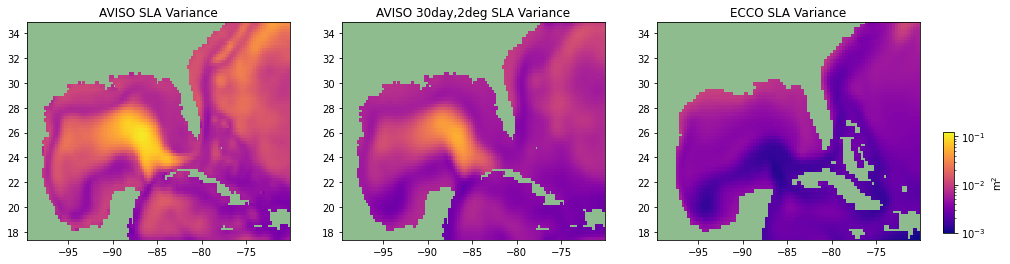

In [53]:
f, (ax,ax2,ax3) = plt.subplots(1,3,figsize=(16,4)); clim = [-0.02, 0.02];
colMap = plt.get_cmap('plasma'); # colMap.set_over(color='r');

Kc = ax.pcolor(av.longitude,av.latitude,avsla_raw.var(dim='time'), norm=LogNorm(vmin=0.001, vmax=0.125),cmap=colMap); 
ax.set_title('AVISO SLA Variance'); 
ax.set_xlim([av.longitude[2], av.longitude[-1]]); ax.set_ylim([av.latitude[0], av.latitude[-1]]); ax.set_facecolor('#8FBC8F');

Kc = ax2.pcolor(av.longitude,av.latitude,np.nanvar(avsla_month,axis=0),norm=LogNorm(vmin=0.001,vmax=0.125),cmap=colMap); 
ax2.set_title('AVISO 30day,2deg SLA Variance'); 
ax2.set_xlim([av.longitude[2], av.longitude[-1]]); ax2.set_ylim([av.latitude[0], av.latitude[-1]]); ax2.set_facecolor('#8FBC8F');

Kc = ax3.pcolor(lons,lats,ssh_anom_2.var(dim='time'), norm=LogNorm(vmin=0.001, vmax=0.125),cmap=colMap); 
ax3.set_title('ECCO SLA Variance'); 
ax3.set_xlim([av.longitude[2], av.longitude[-1]]); ax3.set_ylim([av.latitude[0], av.latitude[-1]]); ax3.set_facecolor('#8FBC8F');

cbpos = [0.92, 0.15, 0.01, 0.35]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', label=r'm$^2$') #extend='both'
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_17/GOM_sla_aviso_var.jpg', dpi=250)

In [9]:
# pick one site to consider time series 
lon_site = -84; lat_site = 28; 
# lon_site = -86; lat_site = 26; 
ecli = np.where((lons > lon_site-.65) & (lons < lon_site+.65) & (lats > lat_site-.65) & (lats < lat_site+.65))
eclon = lons[ecli[0][0], ecli[1][0]]; eclat = lats[ecli[0][0], ecli[1][0]]
# find aviso index to site selected above
avloni = np.where((av.longitude > eclon-.15) & (av.longitude < eclon+.15))[0][0]
avlati = np.where((av.latitude > eclat-.15) & (av.latitude < eclat+.15))[0][0]

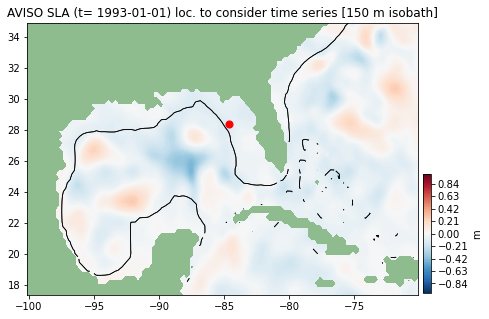

In [10]:
f, ax = plt.subplots(1,1,figsize=(7,5)); clim = [-0.02, 0.02];
colMap = plt.get_cmap('RdBu_r'); # colMap.set_over(color='r');
Kc = ax.contourf(av.longitude,av.latitude,avsla_raw[0],levels=np.arange(-1, 1.01, 0.01), vmin=-1, vmax=1.01,cmap=colMap); 
ax.contour(lons, lats, dep.isel(tile=tile_num), [150, 152], linewidths=0.75, colors='k')
ax.scatter(av.longitude[avloni], av.latitude[avlati], color='r', s=50)
ax.set_title('AVISO SLA (t= ' + str(av.time[0].data)[0:10] + ') loc. to consider time series [150 m isobath]'); 
ax.set_xlim([av.longitude[0], av.longitude[-1]]); ax.set_ylim([av.latitude[0], av.latitude[-1]]); ax.set_facecolor('#8FBC8F');
cbpos = [0.91, 0.13, 0.015, 0.33]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', label='m') #extend='both'
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_17/GOM_sla_aviso_loc.jpg', dpi=250)

In [63]:
avsla_trend_time_1 =av.time[av_time_o].sel(time=slice("1993-01-01", "2003-12-31"))
avsla_trend_time_2 =av.time[av_time_o].sel(time=slice("2007-01-01", "2017-12-31"))
avsla_raw_1 = avsla_raw.sel(time=slice("1993-01-01", "2003-12-31"))
avsla_raw_2 = avsla_raw.sel(time=slice("2007-01-01", "2017-12-31"))
pavsla_1 = avsla_raw_1.polyfit(dim='time', deg=1)
pavsla_2 = avsla_raw_2.polyfit(dim='time', deg=1)
avsla_trend_1 = xr.polyval(avsla_raw_1['time'], pavsla_1.polyfit_coefficients)
avsla_trend_2 = xr.polyval(avsla_raw_2['time'], pavsla_2.polyfit_coefficients)

In [78]:
ectime = ecco_monthly_ds.time
ecsla_trend_time_1 = ectime.sel(time=slice("1993-01-01", "2003-12-31"))
ecsla_trend_time_2 = ectime.sel(time=slice("2007-01-01", "2017-12-31"))
ecsla_raw_1 = ssh_anom_2.sel(time=slice("1993-01-01", "2003-12-31"))
ecsla_raw_2 = ssh_anom_2.sel(time=slice("2007-01-01", "2017-12-31"))
pecsla_1 = ecsla_raw_1.polyfit(dim='time', deg=1)
pecsla_2 = ecsla_raw_2.polyfit(dim='time', deg=1)
ecsla_trend_1 = xr.polyval(ecsla_raw_1['time'], pecsla_1.polyfit_coefficients)
ecsla_trend_2 = xr.polyval(ecsla_raw_2['time'], pecsla_2.polyfit_coefficients)

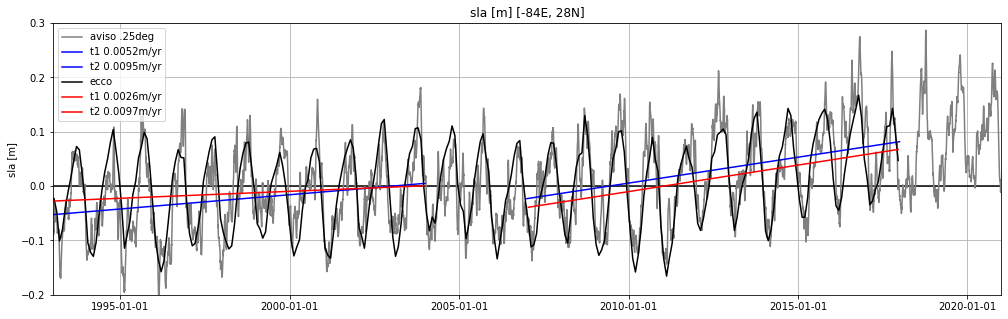

In [85]:
f, (ax) = plt.subplots(1,1,figsize=(17,5))
# -- zero 
ax.plot([av.time[0].data, av.time[-1].data], [0, 0],  color='k')
# -- aviso 
ax.plot(av.time[av_time_o], avsla_raw[:, avlati, avloni], label='aviso .25deg', color='#808080'); 
# -- aviso trends 
ax.plot(avsla_trend_time_1, avsla_trend_1[:, avlati, avloni], \
        label='t1 ' + str(np.round(pavsla_1.polyfit_coefficients[0, avlati, avloni].data*1e9*60*60*24*365,4)) + 'm/yr', color='b'); 
ax.plot(avsla_trend_time_2, avsla_trend_2[:, avlati, avloni], \
        label='t2 ' + str(np.round(pavsla_2.polyfit_coefficients[0, avlati, avloni].data*1e9*60*60*24*365,4)) + 'm/yr', color='b'); 
# -- ecco 
ax.plot(ecco_monthly_ds.time, ssh_anom_2[:,ecli[0][0], ecli[1][0]], label='ecco', color='k')
# -- ecco trends
ax.plot(ecsla_trend_time_1, ecsla_trend_1[:,ecli[0][0], ecli[1][0]], \
        label='t1 ' + str(np.round(pecsla_1.polyfit_coefficients[0,ecli[0][0], ecli[1][0]].data*1e9*60*60*24*365,4)) + 'm/yr', color='r'); 
ax.plot(ecsla_trend_time_2, ecsla_trend_2[:,ecli[0][0], ecli[1][0]], \
        label='t2 ' + str(np.round(pecsla_2.polyfit_coefficients[0,ecli[0][0], ecli[1][0]].data*1e9*60*60*24*365,4)) + 'm/yr', color='r'); 
# -- plot details 
ax.set_title('sla [m] [' + str(lon_site) + 'E, ' + str(lat_site) + 'N]'); 
ax.set_ylabel('sla [m]')
ax.legend(fontsize=10); ax.grid(); ax.set_xlim([av.time[0].data, av.time[-1].data])
ax.set_xticks([np.datetime64('1995'), np.datetime64('2000'), \
               np.datetime64('2005'), np.datetime64('2010'), np.datetime64('2015'), np.datetime64('2020')])
ax.set_ylim([-0.2,0.3])
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_17/GOM_sla_ecco_aviso_trends.jpg', dpi=250)

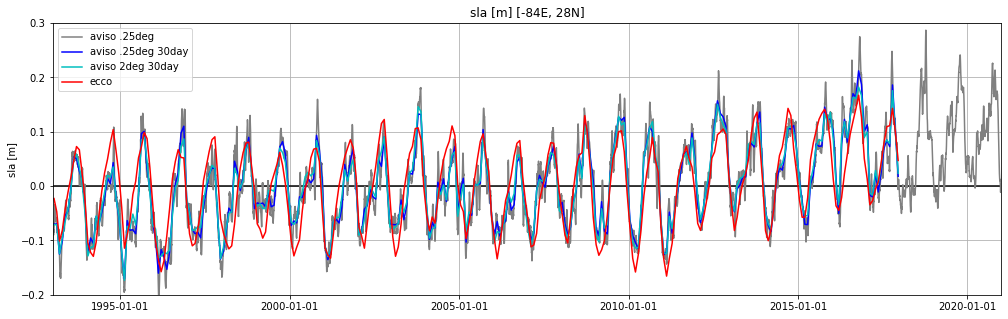

In [76]:
filt_win = 30 # 365*2
f, (ax) = plt.subplots(1,1,figsize=(17,5))
# -- zero 
ax.plot([av.time[0].data, av.time[-1].data], [0, 0],  color='k')
# -- aviso 
ax.plot(av.time[av_time_o], avsla_raw[:, avlati, avloni], label='aviso .25deg', color='#808080'); 
# ax.plot(av.time[av_time_o], avsla[:, avlati, avloni], label='aviso 2deg'); 
# -- aviso smooth (time filter)
ax.plot(ecco_monthly_ds.time, avsla_raw_month[:, avlati, avloni], label='aviso .25deg 30day', color='b'); 
ax.plot(ecco_monthly_ds.time, avsla_month[:, avlati, avloni], label='aviso 2deg 30day', color='c'); 
# ax.plot(av.time[av_time_o], \
#         (np.convolve(avsla[:, avlati, avloni],np.ones(filt_win))/filt_win)[np.int(filt_win/2):-np.int(filt_win/2)+1], linewidth=2); 
# -- aviso trend 
# ax.plot(av.time[av_time_o], avsla_trend[:, avlati, avloni], label='av trend')
# -- ecco 
# ax.plot(ecco_monthly_ds.time, ssh_anom[:,ecli[0][0], ecli[1][0]], label='ecco', color='r')
ax.plot(ecco_monthly_ds.time, ssh_anom_2[:,ecli[0][0], ecli[1][0]], label='ecco', color='r')
# ax.scatter(ecco_monthly_ds.time, ssh_anom[:,ecli[0][0], ecli[1][0]], s=5, color='r')
# -- plot details 
ax.set_title('sla [m] [' + str(lon_site) + 'E, ' + str(lat_site) + 'N]'); 
ax.set_ylabel('sla [m]')
ax.legend(fontsize=10); ax.grid(); ax.set_xlim([av.time[0].data, av.time[-1].data])
ax.set_xticks([np.datetime64('1995'), np.datetime64('2000'), \
               np.datetime64('2005'), np.datetime64('2010'), np.datetime64('2015'), np.datetime64('2020')])
ax.set_ylim([-0.2,0.3])
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_17/GOM_sla_ecco_aviso.jpg', dpi=250)

In [86]:
# re-grid ecco to aviso (0.25 deg) 
avlon, avlat = np.meshgrid(av.longitude, av.latitude)
ecco_avgrid = np.nan*np.ones(np.shape(avsla_month))
for i in range(np.shape(avsla_month)[0]):
    sla2 = ssh_anom_2[i]  # remove global mean time series or not? 
    test = interpolate.griddata(np.concatenate((lons.data.flatten()[:,None], lats.data.flatten()[:,None]), axis=1), \
                                sla2.data.flatten(), np.concatenate((avlon.flatten()[:,None], avlat.flatten()[:,None]), axis=1), \
                                method='linear', fill_value=-1000)
    ecco_avgrid[i,:,:] = test.reshape(len(av.latitude),len(av.longitude))
    # print(i/np.shape(avsla_month)[0])

In [87]:
# compute skill 
skill_raw = np.nanvar(ecco_avgrid - avsla_raw_month, axis=0)/np.nanvar(avsla_raw_month,axis=0)
skill_filt = np.nanvar(ecco_avgrid - avsla_month, axis=0)/np.nanvar(avsla_month,axis=0)

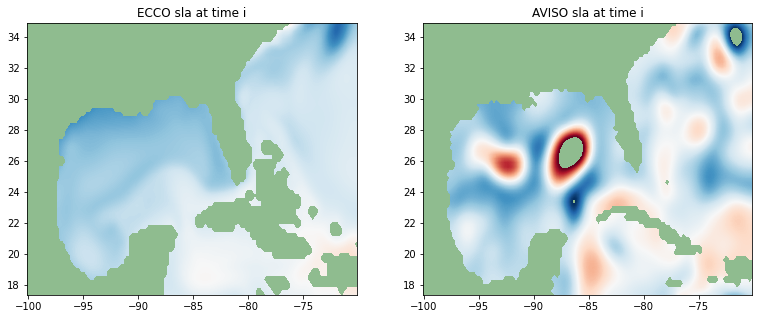

In [88]:
# compare ecco and aviso at some time 
f, (ax,ax2) = plt.subplots(1,2,figsize=(13,5)); clim = [-0.25, 0.25];
colMap = plt.get_cmap('RdBu_r'); # colMap.set_over(color='r');
#  -- to plot trend if desired 
# Kc = ax.contourf(av.longitude,av.latitude,pavsla.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365, \
#             levels=np.arange(clim[0], clim[-1], 0.001), vmin=clim[0],vmax=clim[-1], cmap=colMap); ax.set_facecolor('#8FBC8F')

Kc = ax.contourf(av.longitude,av.latitude,ecco_avgrid[61],levels=np.arange(clim[0], clim[1], 0.001),vmin=clim[0],vmax=clim[-1],cmap=colMap); 
Kc = ax2.contourf(av.longitude,av.latitude,avsla_month[61],levels=np.arange(clim[0], clim[1], 0.001),vmin=clim[0],vmax=clim[-1],cmap=colMap); 
ax.set_facecolor('#8FBC8F')
ax.set_title('ECCO sla at time i'); 
ax.set_xlim([av.longitude[0], av.longitude[-1]]); ax.set_ylim([av.latitude[0], av.latitude[-1]]);
ax2.set_facecolor('#8FBC8F')
ax2.set_title('AVISO sla at time i'); 
ax2.set_xlim([av.longitude[0], av.longitude[-1]]); ax2.set_ylim([av.latitude[0], av.latitude[-1]]);
plt.show()

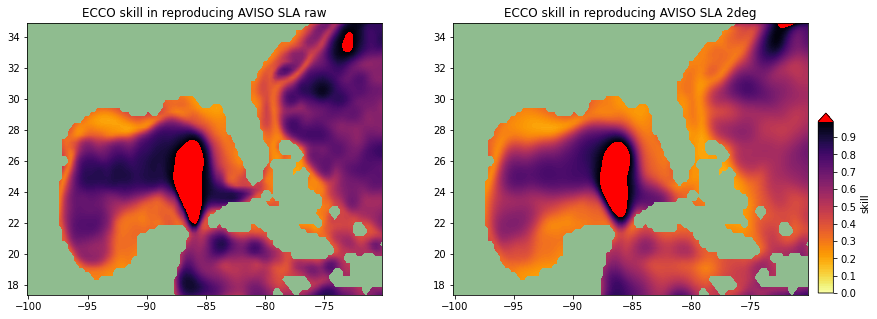

In [89]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5)); clim = [-0.02, 0.02];
colMap = plt.get_cmap('inferno_r'); colMap.set_over(color='r');

Kc = ax1.contourf(av.longitude,av.latitude,skill_raw,levels=np.arange(0, 1, 0.01), vmin=0, vmax=1,cmap=colMap, extend='max'); 
ax1.set_facecolor('#8FBC8F')
ax1.set_title('ECCO skill in reproducing AVISO SLA raw'); 
ax1.set_xlim([av.longitude[0], av.longitude[-1]])
ax1.set_ylim([av.latitude[0], av.latitude[-1]])

Kc = ax2.contourf(av.longitude,av.latitude,skill_filt,levels=np.arange(0, 1, 0.01), vmin=0, vmax=1,cmap=colMap, extend='max'); 
ax2.set_facecolor('#8FBC8F')
ax2.set_title('ECCO skill in reproducing AVISO SLA 2deg'); 
ax2.set_xlim([av.longitude[0], av.longitude[-1]])
ax2.set_ylim([av.latitude[0], av.latitude[-1]])

cbpos = [0.91, 0.13, 0.015, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='skill')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_17/GOM_sla_ecco_aviso_skill.jpg', dpi=250)

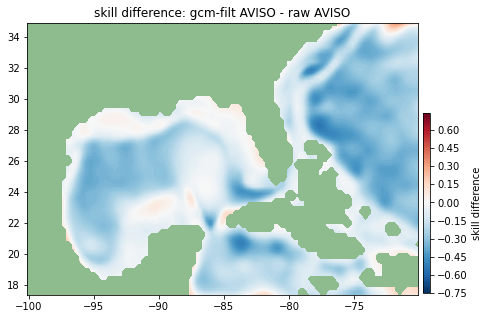

In [82]:
f, ax = plt.subplots(1,1,figsize=(7,5)); clim = [-0.75, 0.75];
colMap = plt.get_cmap('RdBu_r'); 
Kc = ax.contourf(av.longitude,av.latitude,skill_filt-skill_raw,\
                 levels=np.arange(clim[0], clim[-1], 0.01), vmin=clim[0], vmax=clim[-1], cmap=colMap); 
ax.set_title('skill difference: gcm-filt AVISO - raw AVISO'); 
ax.set_xlim([av.longitude[0], av.longitude[-1]]); ax.set_ylim([av.latitude[0], av.latitude[-1]]); ax.set_facecolor('#8FBC8F');
cbpos = [0.91, 0.13, 0.015, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='skill difference')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_03_17/GOM_sla_ecco_aviso_skill_dif.jpg', dpi=250)